In [263]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy.stats import gaussian_kde
from matplotlib import pyplot as plt
import seaborn as sns

In [264]:
species = 'uplsan'

species_lookup = {
    'semplo': 'Semipalmated Plover', 
    'greyel': 'Greater Yellowlegs', 
    'lobcur': 'Long-billed Curlew', 
    'uplsan': 'Upland Sandpiper', 
}
plot_label = species_lookup[species]
filepath = f'detections/{species_lookup[species].replace(' ', '_').lower()}.csv'

/var/folders/4p/8ggqs4cx6gbfrt7g4zcs2z4c0000gn/T/ipykernel_2871/2282593856.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


reviewStatus
Unreviewed    74021
Reviewed        619
Problem          69
Name: count, dtype: int64

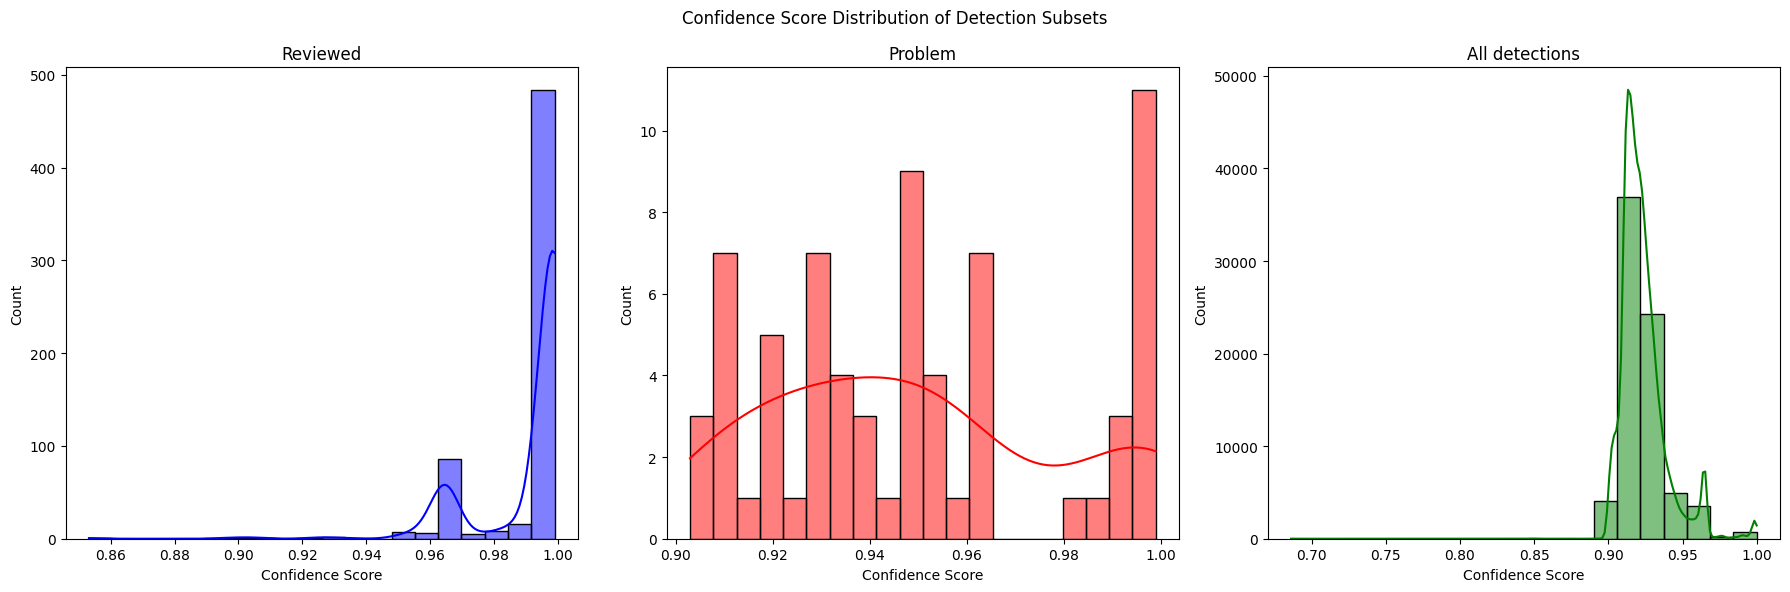

In [265]:
df = pd.read_csv(filepath)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(df[df['reviewStatus'] == 'Reviewed']['confidenceScore'].values, bins=20, kde=True, color='b', ax=axes[0])
sns.histplot(df[df['reviewStatus'] == 'Problem']['confidenceScore'].values, bins=20, kde=True, color='r', ax=axes[1])
sns.histplot(df['confidenceScore'].values, bins=20, kde=True, color='g', ax=axes[2])
axes[0].set_title('Reviewed')
axes[1].set_title('Problem')
axes[2].set_title('All detections')
axes[0].set_xlabel('Confidence Score')
axes[1].set_xlabel('Confidence Score')
axes[2].set_xlabel('Confidence Score')
plt.suptitle('Confidence Score Distribution of Detection Subsets')
plt.tight_layout()

df['reviewStatus'].value_counts()

In [266]:
df['reviewStatusBinary'] = df['reviewStatus'].map({'Reviewed': 1, 'Problem': 0, 'Unreviewed': -1})
df_reviewed = df[df['reviewStatusBinary'] >= 0]

scores = df['confidenceScore']
scores_reviewed = df_reviewed['confidenceScore']

kde = gaussian_kde(scores)
kde_reviewed = gaussian_kde(scores_reviewed)
weights = kde.evaluate(scores_reviewed) / kde_reviewed.evaluate(scores_reviewed)
weights /= weights.sum()

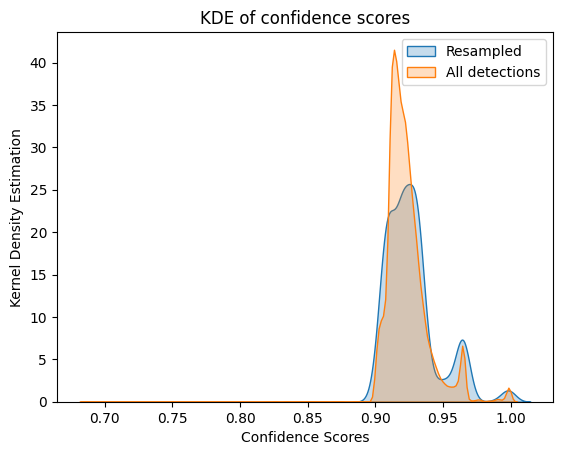

In [267]:
indicies = np.random.choice(df_reviewed.index, size=len(df_reviewed), p=weights, replace=True)
df_resampled = df_reviewed.loc[indicies]

X = df_resampled['confidenceScore'].values.reshape(-1, 1) # X.shape = (N, 1)
y = df_resampled['reviewStatusBinary'].values # y.shape = (N)

sns.kdeplot(X, fill=True, label='Resampled')
sns.kdeplot(scores, fill=True, label='All detections')
plt.title('KDE of confidence scores')
plt.xlabel('Confidence Scores')
plt.ylabel('Kernel Density Estimation')
plt.legend()

logr = LogisticRegression()
logr.fit(X, y)

x_range = np.linspace(0, 1, 100).reshape(-1, 1)
y_prob = logr.predict_proba(x_range)[:, 1]

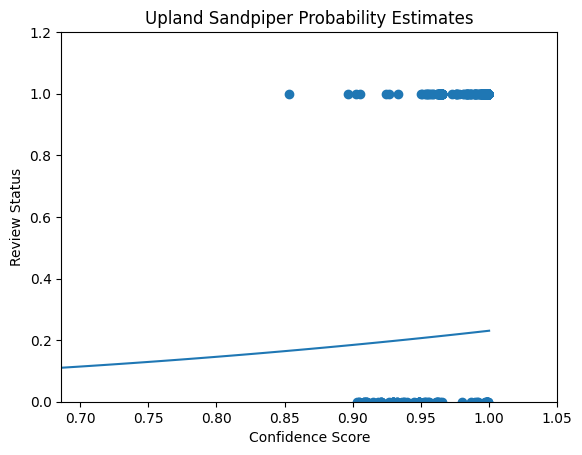

In [268]:
plt.scatter(df['confidenceScore'], df['reviewStatusBinary'])
plt.xlim(df['confidenceScore'].min(), 1.05)
plt.ylim(0, 1.2)
plt.xlabel('Confidence Score')
plt.ylabel('Review Status')
plt.title(f'{plot_label} Probability Estimates')
plt.plot(x_range, y_prob)